In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_csv('/content/sentiment.csv')

In [ ]:
df.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,7/08/2015 9:54,6.296970e+17,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,7/08/2015 9:54,6.296970e+17,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,7/08/2015 9:54,6.296970e+17,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,7/08/2015 9:54,6.296970e+17,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,7/08/2015 9:54,6.296970e+17,NaN,Arizona


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13871 entries, 0 to 13870
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         13871 non-null  int64  
 1   candidate                  13775 non-null  object 
 2   candidate_confidence       13871 non-null  float64
 3   relevant_yn                13871 non-null  object 
 4   relevant_yn_confidence     13871 non-null  float64
 5   sentiment                  13871 non-null  object 
 6   sentiment_confidence       13871 non-null  float64
 7   subject_matter             13545 non-null  object 
 8   subject_matter_confidence  13871 non-null  float64
 9   candidate_gold             28 non-null     object 
 10  name                       13871 non-null  object 
 11  relevant_yn_gold           32 non-null     object 
 12  retweet_count              13871 non-null  int64  
 13  sentiment_gold             15 non-null     obj

In [ ]:
df.isnull().sum()

id                               0
candidate                       96
candidate_confidence             0
relevant_yn                      0
relevant_yn_confidence           0
sentiment                        0
sentiment_confidence             0
subject_matter                 326
subject_matter_confidence        0
candidate_gold               13843
name                             0
relevant_yn_gold             13839
retweet_count                    0
sentiment_gold               13856
subject_matter_gold          13853
text                             0
tweet_coord                  13850
tweet_created                    0
tweet_id                         0
tweet_location                3912
user_timezone                 4403
dtype: int64

In [ ]:
df.columns

Index(['id', 'candidate', 'candidate_confidence', 'relevant_yn',
       'relevant_yn_confidence', 'sentiment', 'sentiment_confidence',
       'subject_matter', 'subject_matter_confidence', 'candidate_gold', 'name',
       'relevant_yn_gold', 'retweet_count', 'sentiment_gold',
       'subject_matter_gold', 'text', 'tweet_coord', 'tweet_created',
       'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')

In [ ]:
existing_columns = list(df.columns)
print(existing_columns)

['id', 'candidate', 'candidate_confidence', 'relevant_yn', 'relevant_yn_confidence', 'sentiment', 'sentiment_confidence', 'subject_matter', 'subject_matter_confidence', 'candidate_gold', 'name', 'relevant_yn_gold', 'retweet_count', 'sentiment_gold', 'subject_matter_gold', 'text', 'tweet_coord', 'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone']


In [ ]:
columns_to_drop = [col for col in ['user_name', 'user_location', ...] if col in existing_columns]

In [ ]:
text_df = df.drop(columns_to_drop, axis=1)
text_df.head()


,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,7/08/2015 9:54,6.296970e+17,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,7/08/2015 9:54,6.296970e+17,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,7/08/2015 9:54,6.296970e+17,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,7/08/2015 9:54,6.296970e+17,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,7/08/2015 9:54,6.296970e+17,NaN,Arizona


In [ ]:
print(text_df['text'].iloc[0],"\n")
print(text_df['text'].iloc[1],"\n")
print(text_df['text'].iloc[2],"\n")
print(text_df['text'].iloc[3],"\n")
print(text_df['text'].iloc[4],"\n")

RT @NancyLeeGrahn: How did everyone feel about the Climate Change question last night? Exactly. #GOPDebate 

RT @ScottWalker: Didn't catch the full #GOPdebate last night. Here are some of Scott's best lines in 90 seconds. #Walker16 http://t.co/ZSfF… 

RT @TJMShow: No mention of Tamir Rice and the #GOPDebate was held in Cleveland? Wow. 

RT @RobGeorge: That Carly Fiorina is trending -- hours after HER debate -- above any of the men in just-completed #GOPdebate says she's on … 

RT @DanScavino: #GOPDebate w/ @realDonaldTrump delivered the highest ratings in the history of presidential debates. #Trump2016 http://t.co… 



In [ ]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13871 entries, 0 to 13870
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         13871 non-null  int64  
 1   candidate                  13775 non-null  object 
 2   candidate_confidence       13871 non-null  float64
 3   relevant_yn                13871 non-null  object 
 4   relevant_yn_confidence     13871 non-null  float64
 5   sentiment                  13871 non-null  object 
 6   sentiment_confidence       13871 non-null  float64
 7   subject_matter             13545 non-null  object 
 8   subject_matter_confidence  13871 non-null  float64
 9   candidate_gold             28 non-null     object 
 10  name                       13871 non-null  object 
 11  relevant_yn_gold           32 non-null     object 
 12  retweet_count              13871 non-null  int64  
 13  sentiment_gold             15 non-null     obj

In [ ]:
def data_processing(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','',text)
    text = re.sub(r'[^\w\s]','',text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

In [ ]:
text_df.text = text_df['text'].apply(data_processing)

In [ ]:
text_df = text_df.drop_duplicates('text')

In [ ]:
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [ ]:
text_df['text'] = text_df['text'].apply(lambda x: stemming(x))

In [ ]:
text_df.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,rt nancyleegrahn everyone feel climate change ...,NaN,7/08/2015 9:54,6.296970e+17,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,rt scottwalker didnt catch full gopdebate last...,NaN,7/08/2015 9:54,6.296970e+17,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,rt tjmshow mention tamir rice gopdebate held c...,NaN,7/08/2015 9:54,6.296970e+17,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,rt robgeorge carly fiorina trending hours deba...,NaN,7/08/2015 9:54,6.296970e+17,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,rt danscavino gopdebate w realdonaldtrump deli...,NaN,7/08/2015 9:54,6.296970e+17,NaN,Arizona


In [ ]:
print(text_df['text'].iloc[0],"\n")
print(text_df['text'].iloc[1],"\n")
print(text_df['text'].iloc[2],"\n")
print(text_df['text'].iloc[3],"\n")
print(text_df['text'].iloc[4],"\n")

rt nancyleegrahn everyone feel climate change question last night exactly gopdebate 

rt scottwalker didnt catch full gopdebate last night scotts best lines 90 seconds walker16 httptcozsff 

rt tjmshow mention tamir rice gopdebate held cleveland wow 

rt robgeorge carly fiorina trending hours debate men justcompleted gopdebate says shes 

rt danscavino gopdebate w realdonaldtrump delivered highest ratings history presidential debates trump2016 httptco 



In [ ]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10371 entries, 0 to 13857
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10371 non-null  int64  
 1   candidate                  10282 non-null  object 
 2   candidate_confidence       10371 non-null  float64
 3   relevant_yn                10371 non-null  object 
 4   relevant_yn_confidence     10371 non-null  float64
 5   sentiment                  10371 non-null  object 
 6   sentiment_confidence       10371 non-null  float64
 7   subject_matter             10090 non-null  object 
 8   subject_matter_confidence  10371 non-null  float64
 9   candidate_gold             0 non-null      object 
 10  name                       10371 non-null  object 
 11  relevant_yn_gold           1 non-null      object 
 12  retweet_count              10371 non-null  int64  
 13  sentiment_gold             1 non-null      object 


In [ ]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [ ]:
text_df['polarity'] = text_df['text'].apply(polarity)

In [ ]:
text_df.head(10)

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone,polarity
0,1,No candidate mentioned,1.0000,yes,1.0000,Neutral,0.6578,None of the above,1.0000,NaN,...,5,NaN,NaN,rt nancyleegrahn everyone feel climate change ...,NaN,7/08/2015 9:54,6.296970e+17,NaN,Quito,0.125000
1,2,Scott Walker,1.0000,yes,1.0000,Positive,0.6333,None of the above,1.0000,NaN,...,26,NaN,NaN,rt scottwalker didnt catch full gopdebate last...,NaN,7/08/2015 9:54,6.296970e+17,NaN,NaN,0.450000
2,3,No candidate mentioned,1.0000,yes,1.0000,Neutral,0.6629,None of the above,0.6629,NaN,...,27,NaN,NaN,rt tjmshow mention tamir rice gopdebate held c...,NaN,7/08/2015 9:54,6.296970e+17,NaN,NaN,0.100000
3,4,No candidate mentioned,1.0000,yes,1.0000,Positive,1.0000,None of the above,0.7039,NaN,...,138,NaN,NaN,rt robgeorge carly fiorina trending hours deba...,NaN,7/08/2015 9:54,6.296970e+17,Texas,Central Time (US & Canada),0.000000
4,5,Donald Trump,1.0000,yes,1.0000,Positive,0.7045,None of the above,1.0000,NaN,...,156,NaN,NaN,rt danscavino gopdebate w realdonaldtrump deli...,NaN,7/08/2015 9:54,6.296970e+17,NaN,Arizona,0.000000
5,6,Ted Cruz,0.6332,yes,1.0000,Positive,0.6332,None of the above,1.0000,NaN,...,228,NaN,NaN,rt gregabbott_tx tedcruz first day rescind eve...,NaN,7/08/2015 9:54,6.296970e+17,NaN,Central Time (US & Canada),-0.050000
6,7,No candidate mentioned,1.0000,yes,1.0000,Negative,0.6761,FOX News or Moderators,1.0000,NaN,...,17,NaN,NaN,rt arriorwoman91 liked happy heard going moder...,NaN,7/08/2015 9:54,6.296970e+17,North Georgia,Eastern Time (US & Canada),0.700000
7,8,No candidate mentioned,1.0000,yes,1.0000,Neutral,1.0000,None of the above,1.0000,NaN,...,0,NaN,NaN,going msnbc live thomasaroberts around 2 pm et...,NaN,7/08/2015 9:54,6.296970e+17,New York NY,Eastern Time (US & Canada),0.136364
8,9,Ben Carson,1.0000,yes,1.0000,Negative,0.6889,None of the above,0.6444,NaN,...,0,NaN,NaN,deer headlights rt lizzwinstead ben carson may...,NaN,7/08/2015 9:54,6.296970e+17,NaN,Pacific Time (US & Canada),0.000000
9,10,No candidate mentioned,0.4594,yes,0.6778,Negative,0.6778,None of the above,0.4594,NaN,...,1,NaN,NaN,rt nancyosborne180 last nights debate proved g...,NaN,7/08/2015 9:54,6.296970e+17,NaN,NaN,0.000000


In [ ]:
def sentiment(label):
    if label <0:
        return "Negative"
    elif label ==0:
        return "Neutral"
    elif label>0:
        return "Positive"

In [ ]:
text_df['sentiment'] = text_df['polarity'].apply(sentiment)

In [ ]:
text_df.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone,polarity
0,1,No candidate mentioned,1.0,yes,1.0,Positive,0.6578,None of the above,1.0000,NaN,...,5,NaN,NaN,rt nancyleegrahn everyone feel climate change ...,NaN,7/08/2015 9:54,6.296970e+17,NaN,Quito,0.125
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,26,NaN,NaN,rt scottwalker didnt catch full gopdebate last...,NaN,7/08/2015 9:54,6.296970e+17,NaN,NaN,0.450
2,3,No candidate mentioned,1.0,yes,1.0,Positive,0.6629,None of the above,0.6629,NaN,...,27,NaN,NaN,rt tjmshow mention tamir rice gopdebate held c...,NaN,7/08/2015 9:54,6.296970e+17,NaN,NaN,0.100
3,4,No candidate mentioned,1.0,yes,1.0,Neutral,1.0000,None of the above,0.7039,NaN,...,138,NaN,NaN,rt robgeorge carly fiorina trending hours deba...,NaN,7/08/2015 9:54,6.296970e+17,Texas,Central Time (US & Canada),0.000
4,5,Donald Trump,1.0,yes,1.0,Neutral,0.7045,None of the above,1.0000,NaN,...,156,NaN,NaN,rt danscavino gopdebate w realdonaldtrump deli...,NaN,7/08/2015 9:54,6.296970e+17,NaN,Arizona,0.000


<Axes: xlabel='sentiment', ylabel='count'>

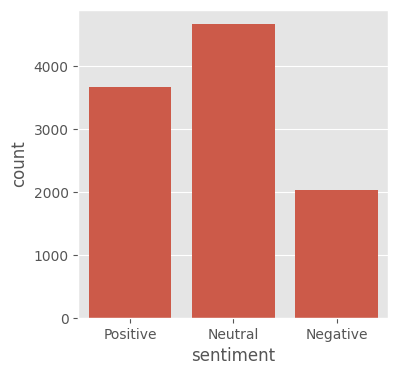

In [ ]:
fig = plt.figure(figsize=(4,4))
sns.countplot(x='sentiment', data = text_df)

Text(0.5, 1.0, 'Distribution of sentiments')

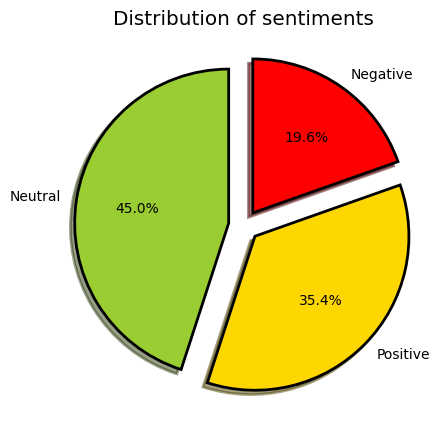

In [ ]:
fig = plt.figure(figsize=(5,5))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = text_df['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [ ]:
pos_tweets = text_df[text_df.sentiment == 'Positive']
pos_tweets = pos_tweets.sort_values(['polarity'], ascending= False)
pos_tweets.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone,polarity
3315,3316,Donald Trump,1.0000,yes,1.0000,Positive,0.3617,FOX News or Moderators,1.0000,NaN,...,0,NaN,NaN,best part gopdebate foxnews viewers choose meg...,NaN,7/08/2015 9:20,6.296890e+17,"Moore, Ok",Central Time (US & Canada),1.0
4661,4662,No candidate mentioned,0.4664,yes,0.6829,Positive,0.3780,None of the above,0.4664,NaN,...,597,NaN,NaN,rt notbillwalton greatest snl sketch alltime g...,NaN,7/08/2015 8:46,6.296800e+17,PA,Eastern Time (US & Canada),1.0
5115,5116,No candidate mentioned,1.0000,yes,1.0000,Positive,1.0000,None of the above,1.0000,NaN,...,0,NaN,NaN,perfect summation gopdebate,NaN,7/08/2015 8:40,6.296780e+17,"24.86° N, 67.01° E",Eastern Time (US & Canada),1.0
5093,5094,No candidate mentioned,1.0000,yes,1.0000,Positive,0.6842,None of the above,1.0000,NaN,...,1,NaN,NaN,rt marnus3 perfect remedy gopdebate hangover f...,NaN,7/08/2015 8:40,6.296790e+17,28277,Hawaii,1.0
574,575,No candidate mentioned,0.4585,yes,0.6771,Positive,0.6771,None of the above,0.4585,NaN,...,182,NaN,NaN,rt fredzeppelin12 priceless carlyfiorina clean...,NaN,7/08/2015 9:50,6.296960e+17,http://www.ojjpac.org/memorial,Central Time (US & Canada),1.0


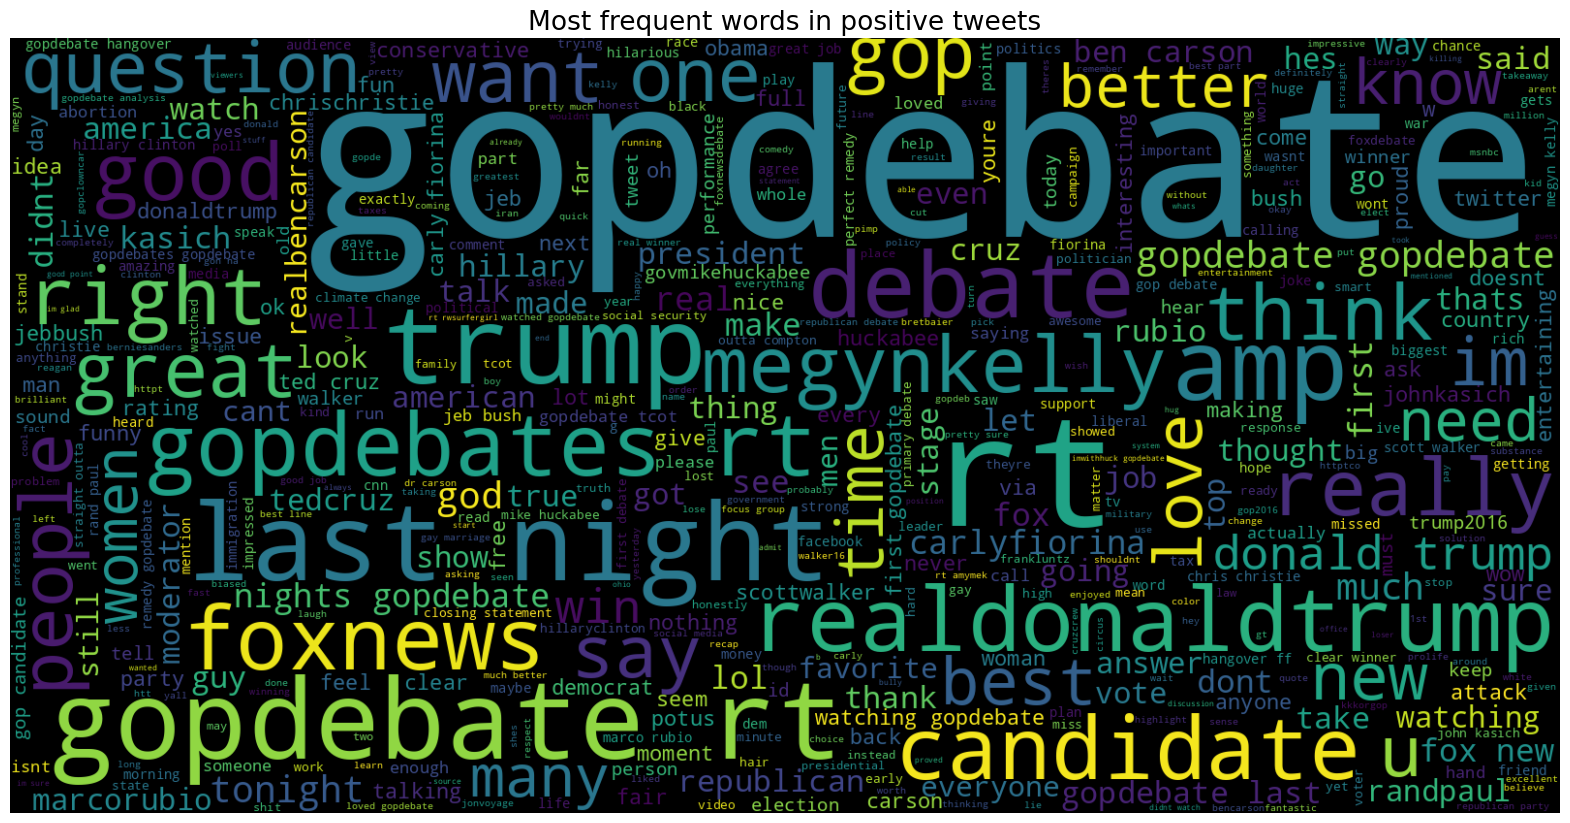

In [ ]:
text = ' '.join([word for word in pos_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive tweets', fontsize=19)
plt.show()

In [ ]:
neg_tweets = text_df[text_df.sentiment == 'Negative']
neg_tweets = neg_tweets.sort_values(['polarity'], ascending= False)
neg_tweets.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone,polarity
11945,11946,No candidate mentioned,1.0000,yes,1.0,Negative,1.0000,None of the above,0.6292,NaN,...,0,NaN,NaN,gopdebates wow really good question starts vio...,NaN,6/08/2015 19:28,6.294790e+17,NaN,NaN,-3.700743e-17
7226,7227,Ben Carson,1.0000,yes,1.0,Negative,1.0000,None of the above,1.0000,NaN,...,255,NaN,NaN,rt deray someone go give ben carson pep talk s...,NaN,7/08/2015 8:08,6.296700e+17,West Baltimore,Atlantic Time (Canada),-4.166667e-03
5229,5230,No candidate mentioned,0.6752,yes,1.0,Negative,1.0000,None of the above,0.6752,NaN,...,35,NaN,NaN,rt paulprovenza honor people diedyou mean ones...,NaN,7/08/2015 8:38,6.296780e+17,NaN,NaN,-4.166667e-03
6822,6823,No candidate mentioned,1.0000,yes,1.0,Negative,0.6667,Immigration,1.0000,NaN,...,0,NaN,NaN,candidate consistently talks ampplans cutting ...,NaN,7/08/2015 8:14,6.296720e+17,"Immigrantville, Obamaland",Eastern Time (US & Canada),-5.555556e-03
1709,1710,Donald Trump,1.0000,yes,1.0,Negative,1.0000,None of the above,1.0000,NaN,...,2,NaN,NaN,rt danpfeiffer heres late night hot take gopde...,NaN,7/08/2015 9:38,6.296930e+17,Colorado,Mountain Time (US & Canada),-1.000000e-02


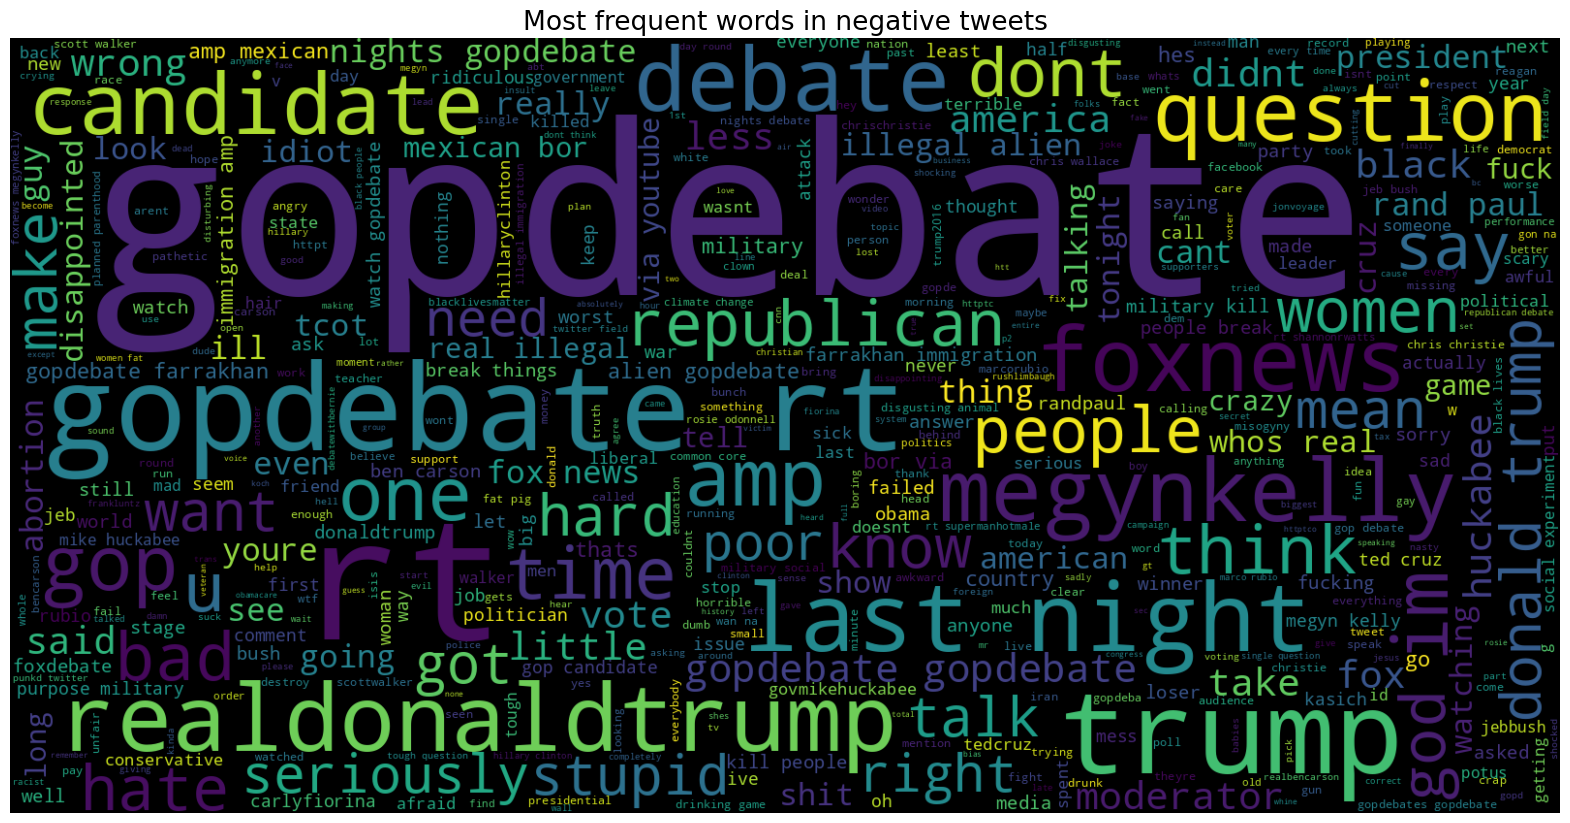

In [ ]:
text = ' '.join([word for word in neg_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in negative tweets', fontsize=19)
plt.show()

In [ ]:
neutral_tweets = text_df[text_df.sentiment == 'Neutral']
neutral_tweets = neutral_tweets.sort_values(['polarity'], ascending= False)
neutral_tweets.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone,polarity
3,4,No candidate mentioned,1.0000,yes,1.0000,Neutral,1.0000,None of the above,0.7039,NaN,...,138,NaN,NaN,rt robgeorge carly fiorina trending hours deba...,NaN,7/08/2015 9:54,6.296970e+17,Texas,Central Time (US & Canada),0.0
7076,7077,No candidate mentioned,0.4584,yes,0.6771,Neutral,0.6771,None of the above,0.4584,NaN,...,0,NaN,NaN,protip dont watch gopdebate drink never dont r...,NaN,7/08/2015 8:10,6.296710e+17,"Dallas, Texas, USA",Central Time (US & Canada),0.0
7037,7038,Donald Trump,0.6703,yes,1.0000,Neutral,0.6484,None of the above,1.0000,NaN,...,0,NaN,NaN,nhgop built nhpolitics gopdebate voteblue2016,NaN,7/08/2015 8:11,6.296710e+17,New Hampshire,Eastern Time (US & Canada),0.0
7032,7033,John Kasich,1.0000,yes,1.0000,Neutral,1.0000,None of the above,1.0000,NaN,...,0,NaN,NaN,wouldnt mind john kasich next president kasich...,NaN,7/08/2015 8:11,6.296710e+17,Texas,Central Time (US & Canada),0.0
7031,7032,Donald Trump,1.0000,yes,1.0000,Neutral,1.0000,None of the above,1.0000,NaN,...,0,NaN,NaN,usprezdebate totally think tanned trump gaffe ...,NaN,7/08/2015 8:11,6.296710e+17,Halifax,Mountain Time (US & Canada),0.0


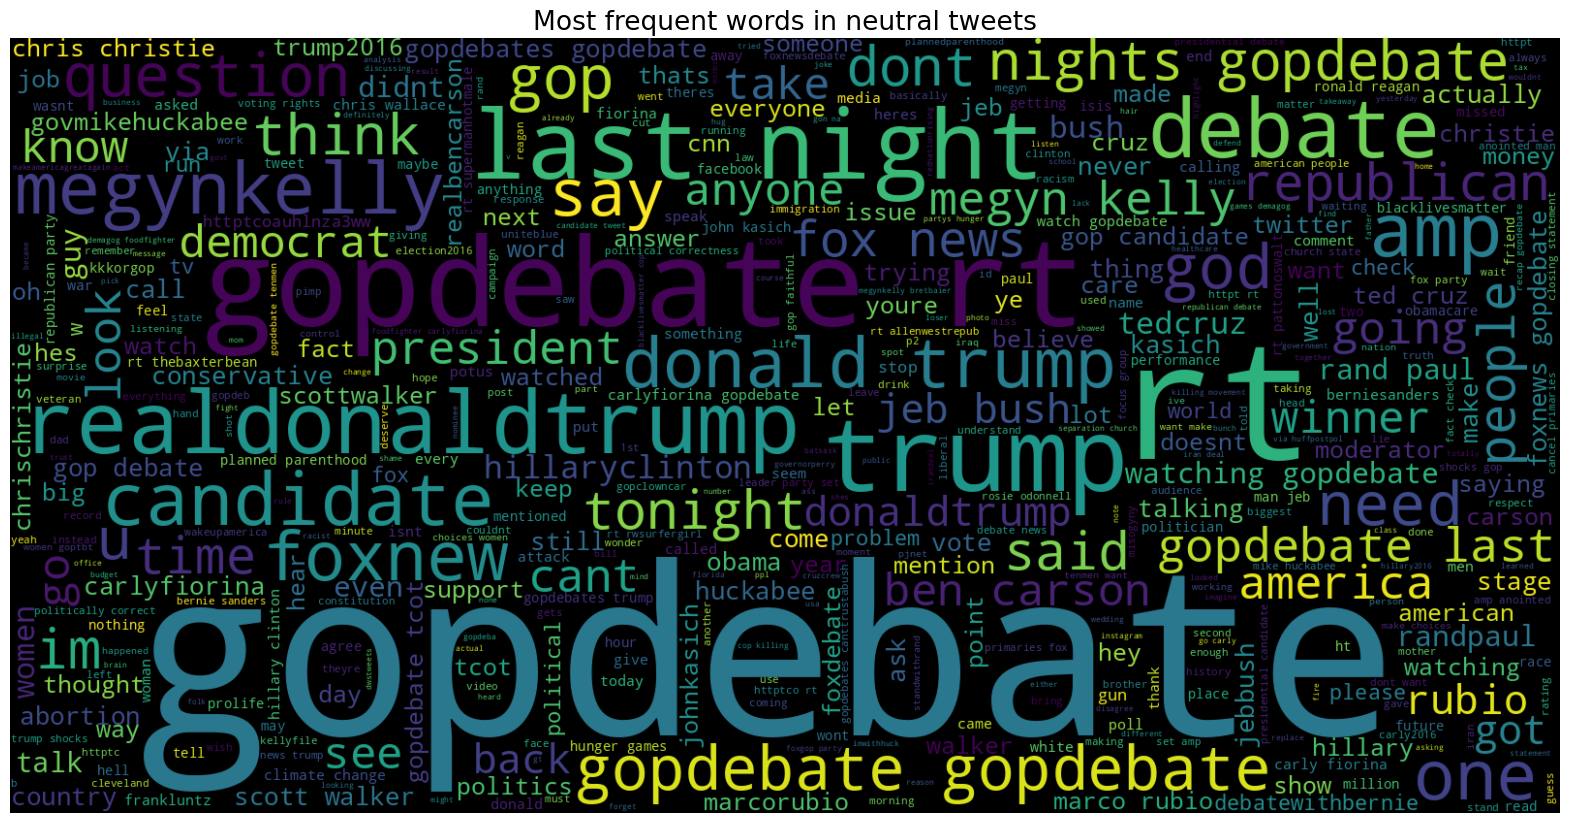

In [ ]:
text = ' '.join([word for word in neutral_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in neutral tweets', fontsize=19)
plt.show()

In [ ]:
vect = CountVectorizer(ngram_range=(1,2)).fit(text_df['text'])

In [ ]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features:\n {}".format(feature_names[:20]))

Number of features: 87355

First 20 features:
 ['07' '07 fun' '0iiiiiii0_girl' '0iiiiiii0_girl take' '10' '10 2001'
 '10 amp' '10 angry' '10 appt' '10 best' '10 billion' '10 candidates'
 '10 carlyfiorina' '10 contenders' '10 couldnt' '10 cringeworthy'
 '10 donation' '10 dreadful' '10 gotten' '10 gov']


In [ ]:
X = text_df['text']
Y = text_df['sentiment']
X = vect.transform(X)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
print("Size of x_train:", (x_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test:", (x_test.shape))
print("Size of y_test:", (y_test.shape))

Size of x_train: (8296, 87355)
Size of y_train: (8296,)
Size of x_test: (2075, 87355)
Size of y_test: (2075,)


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_pred = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 83.04%


In [ ]:
print(confusion_matrix(y_test, logreg_pred))
print("\n")
print(classification_report(y_test, logreg_pred))

[[257 129  33]
 [  6 891   7]
 [ 26 151 575]]


              precision    recall  f1-score   support

    Negative       0.89      0.61      0.73       419
     Neutral       0.76      0.99      0.86       904
    Positive       0.93      0.76      0.84       752

    accuracy                           0.83      2075
   macro avg       0.86      0.79      0.81      2075
weighted avg       0.85      0.83      0.83      2075



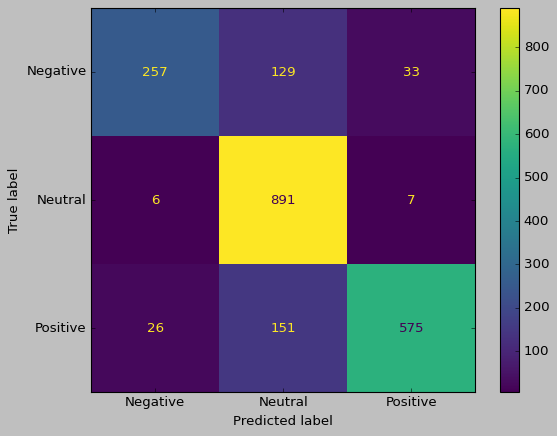

In [ ]:
style.use('classic')
cm = confusion_matrix(y_test, logreg_pred, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=logreg.classes_)
disp.plot()

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid={'C':[0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid)
grid.fit(x_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [ ]:
print("Best parameters:", grid.best_params_)

Best parameters: {'C': 10}


In [ ]:
y_pred = grid.predict(x_test)

In [ ]:
logreg_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 84.10%


In [ ]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[269 119  31]
 [  6 891   7]
 [ 28 139 585]]


              precision    recall  f1-score   support

    Negative       0.89      0.64      0.75       419
     Neutral       0.78      0.99      0.87       904
    Positive       0.94      0.78      0.85       752

    accuracy                           0.84      2075
   macro avg       0.87      0.80      0.82      2075
weighted avg       0.86      0.84      0.84      2075



In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(x_train, y_train)

LinearSVC()

In [ ]:
svc_pred = SVCmodel.predict(x_test)
svc_acc = accuracy_score(svc_pred, y_test)
print("test accuracy: {:.2f}%".format(svc_acc*100))

test accuracy: 86.41%


In [ ]:
print(confusion_matrix(y_test, svc_pred))
print("\n")
print(classification_report(y_test, svc_pred))

[[294  95  30]
 [  7 887  10]
 [ 24 116 612]]


              precision    recall  f1-score   support

    Negative       0.90      0.70      0.79       419
     Neutral       0.81      0.98      0.89       904
    Positive       0.94      0.81      0.87       752

    accuracy                           0.86      2075
   macro avg       0.88      0.83      0.85      2075
weighted avg       0.87      0.86      0.86      2075



In [ ]:
grid = {
    'C':[0.01, 0.1, 1, 10],
    'kernel':["linear","poly","rbf","sigmoid"],
    'degree':[1,3,5,7],
    'gamma':[0.01,1]
}
grid = GridSearchCV(SVCmodel, param_grid)
grid.fit(x_train, y_train)

GridSearchCV(estimator=LinearSVC(), param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [ ]:
print("Best parameter:", grid.best_params_)

Best parameter: {'C': 1}


In [ ]:
y_pred = grid.predict(x_test)

In [ ]:
logreg_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 86.41%


In [ ]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[294  95  30]
 [  7 887  10]
 [ 24 116 612]]


              precision    recall  f1-score   support

    Negative       0.90      0.70      0.79       419
     Neutral       0.81      0.98      0.89       904
    Positive       0.94      0.81      0.87       752

    accuracy                           0.86      2075
   macro avg       0.88      0.83      0.85      2075
weighted avg       0.87      0.86      0.86      2075

